# Titanic

Goal: 승객의 나이, 성별 등의 속성을 기반으로 하여 승객의 생존 예측을 하는 것

현재 directory에 datasets 내에 train.csv와 test.csv 존재

In [1]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

## 1. Exploratory Data

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<ul>
    <li><b>Survived</b>: 타겟, 0은 생존하지 못한 것, 1은 생존</li>
    <li><b>Pclass</b>: 승객 등급. 1, 2, 3등석 </li>
    <li><b>Name, Sex, Age</b>: 이름, 성별, 나이 </li>
    <li><b>SibSp</b>: 함께 탑승한 형제, 배우자의 수</li>
    <li><b>Parch</b>: 함께 탑승한 자녀, 부모의 수</li>
    <li><b>Ticket</b>: 티켓 아이디</li>
    <li><b>Fare</b>: 티켓 요금(파운드) </li>
    <li><b>Cabin</b>: 객실 번호 </li>
    <li><b>Embarekd</b>: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)</li>
</ul>

누락한 데이터 파악

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<span><b>Age, Cabin, Embarked</b>의 일부가 null.</span>
<p><b>Cabin</b>은 77%가 null :(</p>
<b>Name</b>과 <b>Ticket</b> 속성도 값이 있지만, 머신러닝 모델이 사용할 수 있는 숫자로 변환하는 것은 까다롭기에 현재는 무시

통계치 확인

In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


타깃이 0과 1로 이루어져있는지 확인

In [10]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

범주형 특성 확인

In [11]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [13]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [14]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## 2. 전처리 파이프라인

<span style="color:olive">Note</span>: <b>Pipeline, FeatureUnion</b>과 같은 사용자 정의 <b>DataFrameSelector</b> 클래스를 사용하여 각 열을 다르게 전처리함. 사이킷런 0.20부터는 이전에 했던 것처럼 <b>ColumnTransformer</b>를 사용하는 것이 좋음

DataFrameSelector를 재사용하여 DataFrame에서 특정 열을 선택

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

숫자 특성을 위한 파이프라인

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")),
])

In [19]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

문자열로 된 범주형 열을 위해 별도의 Imputer 클래스가 필요 (일반 SimpleImputer 클래스는 이를 처리하지 못함)

In [20]:
# from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [21]:
from sklearn.preprocessing import OneHotEncoder

범주형 특성을 위한 파이프라인

In [22]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [23]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

숫자와 범주형 파이프라인 연결

In [24]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인

In [25]:
X_train = preprocess_pipeline.fit_transform(train_data)
print(X_train)

[[22.  1.  0. ...  0.  0.  1.]
 [38.  1.  0. ...  1.  0.  0.]
 [26.  0.  0. ...  0.  0.  1.]
 ...
 [28.  1.  2. ...  0.  0.  1.]
 [26.  0.  0. ...  1.  0.  0.]
 [32.  0.  0. ...  0.  1.  0.]]


레이블도 가져와야 함

In [27]:
y_train = train_data["Survived"]

## 3. Training

#### 1) SVC

In [28]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

Training done, Predict for test-set

In [29]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

캐글에 업로드하기 위해 csv형태로 재구성할 수 있음. 하기 전에 교차 검증으로 모델 평가를 해보는 것도 좋다.

In [30]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
print(svm_scores.mean())

0.7329588014981274


#### 2) RandomForestClassifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
print(forest_scores.mean())

0.8126466916354558


In [70]:
forest_clf.fit(X_train, y_train)
y_pred_forest = forest_clf.predict(X_test)

평균 정확도를 보는 대신 모델에서 얻은 10개의 점수를 1사분위, 3사분위를 명료하게 표현해주는 상자 수염 그림(box-and-whisker) 그래프로 확인.
boxplot() 함수는 이상치를 감지하고 수염 부분에 이를 포함시키지 않는다. 

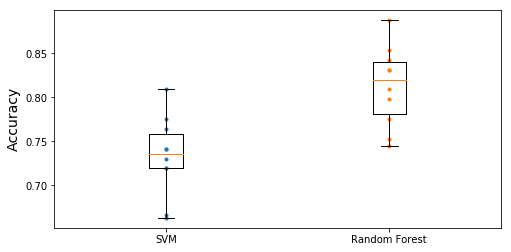

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

결과를 더 향상시키려면
<ul>
    <li>교차 검증과 그리드 탐색을 이용해 더 많은 모델을 비교하고 하이퍼파라미터를 튜닝</li>
    <li>특성 공학?</li>
    <ul>
        <li><b>SibSp</b>와 <b>Parch</b>을 이 두 특성의 합으로 변경</li>
        <li><b>Survived</b> 특성과 관련된 이름을 구별 (예를 들어, 이름에 <b>"Countness"</b>가 있는 경우 생존할 가능성 존재)</li>
    </ul>
    <li>수치 특성을 범주형 특성으로 변경</li>
</ul>

In [38]:
train_data["AgeBucket"] = train_data["Age"]
train_data[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.42,1.0
0.67,1.0
0.75,1.0
0.83,1.0
0.92,1.0
...,...
70.00,0.0
70.50,0.0
71.00,0.0


In [40]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(["RelativesOnboard"]).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


etc...

In [75]:
data_df = pd.DataFrame(y_pred, columns=["Survived"])
data_df_forest = pd.DataFrame(y_pred_forest, columns=["Survived"])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  418 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [51]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [76]:
result = pd.concat([test_data["PassengerId"], data_df], axis=1)
result_forest = pd.concat([test_data["PassengerId"], data_df_forest], axis=1)
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [77]:
result.to_csv("result.csv", index=False)
result_forest.to_csv("result_forest.csv", index=False)